### Language model : Neural probabilistic language model , bengio et. al
##### Associate 30 dim feature vector with every char or word, effectively every word is embedded in 30 dimensional space. In the beginning they are initialized randomly and are then embeddings are tuned using backpropagation for maximizing log likelihood of train data.

##### It has something called lookup table, which is a matrix (vocab-size X embedding-dimension). Input is index of incoming word, used to select a row of embedding matrix which is considered as embedding vecor for the word with that index

##### Then we have hidden layer with tanh non linearity and its size is hyper-param
##### Output layer has as many neurons as vocab size, and all are fully fonnected to hidden layer, then at the end softmax is applied
##### Parameters : Weights and biases of output and hidden layer and lookup table

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['barjraj',
 'ramdin verma',
 'sharat chandran',
 'birender mandal',
 'amit',
 'kushal',
 'kasid',
 'shiv prakash']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}
28


In [5]:
# build dataset

block_size = 3 # context length i.e how many chars we consider for predicting the next one
X,Y = [] , []

for w in words[:5]:
    print(w)

    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context ), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

barjraj
... ---> b
..b ---> a
.ba ---> r
bar ---> j
arj ---> r
rjr ---> a
jra ---> j
raj ---> .
ramdin verma
... ---> r
..r ---> a
.ra ---> m
ram ---> d
amd ---> i
mdi ---> n
din --->  
in  ---> v
n v ---> e
 ve ---> r
ver ---> m
erm ---> a
rma ---> .
sharat chandran
... ---> s
..s ---> h
.sh ---> a
sha ---> r
har ---> a
ara ---> t
rat --->  
at  ---> c
t c ---> h
 ch ---> a
cha ---> n
han ---> d
and ---> r
ndr ---> a
dra ---> n
ran ---> .
birender mandal
... ---> b
..b ---> i
.bi ---> r
bir ---> e
ire ---> n
ren ---> d
end ---> e
nde ---> r
der --->  
er  ---> m
r m ---> a
 ma ---> n
man ---> d
and ---> a
nda ---> l
dal ---> .
amit
... ---> a
..a ---> m
.am ---> i
ami ---> t
mit ---> .


In [6]:
# lookup table containing embedding for characters
C = torch.randn(vocab_size,2)

In [7]:
C[5]

tensor([1.7968, 0.6341])

In [8]:
# pytorch for some reason can't multiply int and float, so we need
# to cast output of F.one_hot to float
F.one_hot(torch.tensor(5), num_classes=vocab_size).float() @ C

tensor([1.7968, 0.6341])

##### Essentially : text dataset --> vocab dictionary --> char/word/token index --> one-hot-encoding --> vector embedding 

##### We can think of embedding of char as indexing into lookup table C or we can think of it as first layer of the Neural Net with weight matrix as C. We are encoding char indices as one hot and feeding them into neral net.

#### We prefer indexing as it is faster, but the interpretation above is useful for overall understanding

In [9]:
# can index into tensor using tensor of indices
C[X].shape, X.shape, Y.shape

(torch.Size([58, 3, 2]), torch.Size([58, 3]), torch.Size([58]))

In [10]:
X[13,2]

tensor(10)

In [11]:
C[X][13,2]

tensor([2.0987, 1.0457])

In [12]:
C[10]

tensor([2.0987, 1.0457])

In [13]:
emb = C[X]
emb.shape

torch.Size([58, 3, 2])

In [14]:
W1 = torch.randn(6,100)
b1 = torch.randn(100)

In [15]:
# emb @ W1 will not work as the dimensions aren't compatible
# so we concatenate
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape

torch.Size([58, 6])

In [16]:
# unbind removes a dimension
# cat creates new tensor
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([58, 6])

##### using views

In [17]:
h = torch.tanh( emb.view(-1,6) @ W1 + b1)

#### Final output has vocab size columns, once exponentiated and normalized, we interpret its rows to contain prob for next word in sequence

In [18]:
W2 = torch.randn(100, vocab_size)
b2 = torch.randn(vocab_size)

In [19]:
logits = h @ W2 + b2

In [20]:
counts = logits.exp()
prob = counts/counts.sum(1, keepdim=True)

In [22]:
Y

tensor([ 3,  2, 19, 11, 19,  2, 11,  0, 19,  2, 14,  5, 10, 15,  1, 23,  6, 19,
        14,  2,  0, 20,  9,  2, 19,  2, 21,  1,  4,  9,  2, 15,  5, 19,  2, 15,
         0,  3, 10, 19,  6, 15,  5,  6, 19,  1, 14,  2, 15,  5,  2, 13,  0,  2,
        14, 10, 21,  0])

In [ ]:
# neg log likelihood
# taking probablity assigned to next character (using its index stored in Y)

# prob[char_index, next_char_index]
# char_index = torch.arange(58) as tensor
# next_char_index = Y as tensor
loss = -prob[torch.arange(58), Y].log().mean()
loss

tensor(14.5624)

## Putting it all together

In [116]:
block_size = 3 # context length i.e how many chars we consider for predicting the next one
X,Y = [] , []

for w in words:
    #print(w)

    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context ), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [117]:
X.shape, Y.shape

(torch.Size([388011, 3]), torch.Size([388011]))

In [118]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, 2), generator=g)

W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

W2 = torch.randn((100, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]

In [76]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts/counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(58), Y].log().mean() # taking probablity assigned to next character

#### As we are only taking probability assigned to actual next character and in traget its value is 1. Neg log likelihood sum(-p_i*log(p_i)) = sum(-1 * log(p_i)) = -sum(log(p_i)), which is same as cross entropy

In [77]:
# optimized by pytroch
# numerically well behaved compared to exponentiation as it can produce NANs for large exponents
# pytorch internally implements corss entropy in a stable manner
loss = F.cross_entropy(logits, Y)

#### Train loop

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
for _ in range(20):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

In [70]:
loss.item()

0.1966908574104309

#### Use SGD using mini batches

In [110]:
for _ in range(20):

    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

2.4509456157684326
2.8563499450683594
2.7200517654418945
2.926348924636841
2.731095314025879
3.164036750793457
2.207893133163452
3.0496060848236084
2.636603355407715
2.833599328994751
2.9269275665283203
2.77936053276062
2.3798680305480957
2.913972854614258
2.5225796699523926
2.4722135066986084
2.987727403640747
2.6731462478637695
2.835904836654663
2.6101174354553223


### Learning rate / step size

In [119]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
for i in range(10000):
    ix = torch.randint(0, X.shape[0], (32,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    #lri.append(lre[i])
    #lossi.append(loss.item())

2.4909775257110596
2.4685275554656982
2.3525781631469727
2.8249943256378174
2.588632822036743
2.69158935546875
2.533214569091797
2.38908052444458
2.4701714515686035
2.6883437633514404
2.6601219177246094
2.803440570831299
2.3642771244049072
2.4090895652770996
2.6269822120666504
2.7716307640075684
2.474632978439331
2.9115827083587646
2.580531597137451
2.5792741775512695
2.7530031204223633
2.79697585105896
2.3685550689697266
2.6813158988952637
2.524103879928589
2.796487331390381
2.1432342529296875
2.7430508136749268
2.3232648372650146
2.5711028575897217
2.585512161254883
2.6923575401306152
2.855335235595703
2.726223945617676
2.4255025386810303
2.6540303230285645
2.7703306674957275
2.5680408477783203
2.502790927886963
2.716761589050293
2.792684555053711
2.5513486862182617
2.4536073207855225
2.6838607788085938
2.720524787902832
2.740262985229492
2.413266897201538
2.579503059387207
2.3954901695251465
2.1780643463134766
2.1588144302368164
2.556220531463623
2.4081215858459473
2.522881269454956

##### plotting step size exponenet vs loss for each iteration, this gives us range suitable for it, once determined usign this method we can use that for training

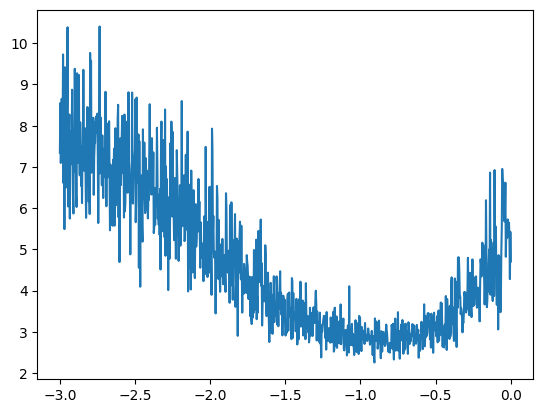

In [126]:
plt.plot(lre,lossi)

In [129]:
loss.item()

2.3179802894592285

### Train Validation Test split

#### Train

In [131]:
def build_dataset(words):
    block_size = 3 # context length i.e how many chars we consider for predicting the next one
    X,Y = [] , []

    for w in words:
        #print(w)

        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context ), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [132]:
Xtr.shape, Ytr.shape

(torch.Size([310156, 3]), torch.Size([310156]))

In [133]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, 2), generator=g)

W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

W2 = torch.randn((100, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]

In [134]:
for p in parameters:
    p.requires_grad = True

In [142]:
for i in range(10000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

2.3513293266296387
2.3817965984344482
2.1818699836730957
2.433180093765259
2.469188690185547
2.4136602878570557
2.3076541423797607
2.2242894172668457
2.650914430618286
2.656456470489502
2.5736818313598633
2.3134043216705322
2.0564370155334473
2.3609256744384766
2.367938756942749
2.4584474563598633
2.1988587379455566
2.4875404834747314
2.40376353263855
2.0228216648101807
2.296130657196045
2.3004586696624756
2.3792712688446045
2.648576259613037
2.5125763416290283
2.622762680053711
2.1246161460876465
2.5331809520721436
2.590468645095825
2.2520370483398438
2.4600958824157715
2.2823522090911865
2.699831247329712
2.064074754714966
2.2139244079589844
2.3631558418273926
2.6637113094329834
2.3019912242889404
2.155268430709839
2.331178903579712
2.824111223220825
2.2243969440460205
2.4404690265655518
2.7834982872009277
2.094926595687866
2.5287740230560303
2.579355001449585
2.57007098197937
2.539073944091797
2.7757749557495117
2.573061227798462
2.195952892303467
2.8075263500213623
2.44638872146606

In [143]:
loss.item()

1.9357242584228516

#### Validate

In [155]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5657, grad_fn=<NllLossBackward0>)

In [156]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5698, grad_fn=<NllLossBackward0>)

#### increasing number of neurons in hidden layers and embedding vector dimension

In [172]:
embedding_size = 10
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, embedding_size), generator=g)

W1 = torch.randn((block_size*embedding_size, 200), generator=g)
b1 = torch.randn(200, generator=g)

W2 = torch.randn((200, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [173]:
stepi = []
lossi = []

In [182]:
for i in range(50000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, block_size*embedding_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    stepi.append(i)
    #lossi.append(loss.item())
    lossi.append(loss.log10().item())
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

2.2543160915374756
2.3384180068969727
2.3645951747894287
2.5337159633636475
2.0783379077911377
2.325841188430786
2.038856029510498
2.9112725257873535
2.163801431655884
2.593674421310425
2.2629971504211426
1.8339020013809204
2.4277968406677246
2.4762918949127197
2.330592155456543
2.3474032878875732
1.954983115196228
2.2786011695861816
2.2558112144470215
2.64162278175354
1.7949366569519043
1.9846020936965942
2.42417573928833
2.2233636379241943
2.0858476161956787
1.8608671426773071
2.3526997566223145
2.2775676250457764
2.325529098510742
2.6738176345825195
2.181725025177002
2.1949234008789062
2.302907705307007
2.0187253952026367
2.5617551803588867
2.2483201026916504
2.214513063430786
2.2301604747772217
1.5159132480621338
1.9610599279403687
2.1167171001434326
2.1817562580108643
2.493187189102173
1.9280853271484375
2.1674692630767822
2.2774851322174072
2.1464827060699463
2.6778621673583984
2.1931450366973877
1.823449730873108
2.0986835956573486
2.3996469974517822
2.303832769393921
2.14793515

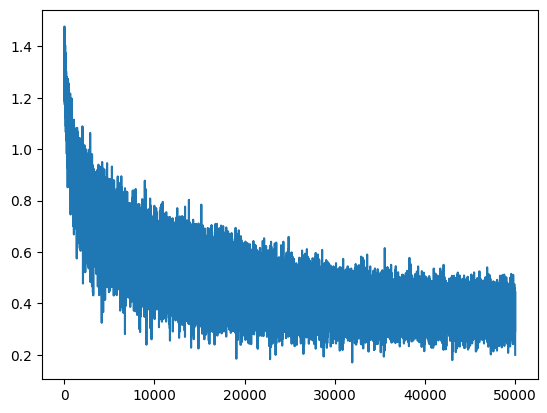

In [175]:
plt.plot(stepi, lossi)

#### visualizing character embedings

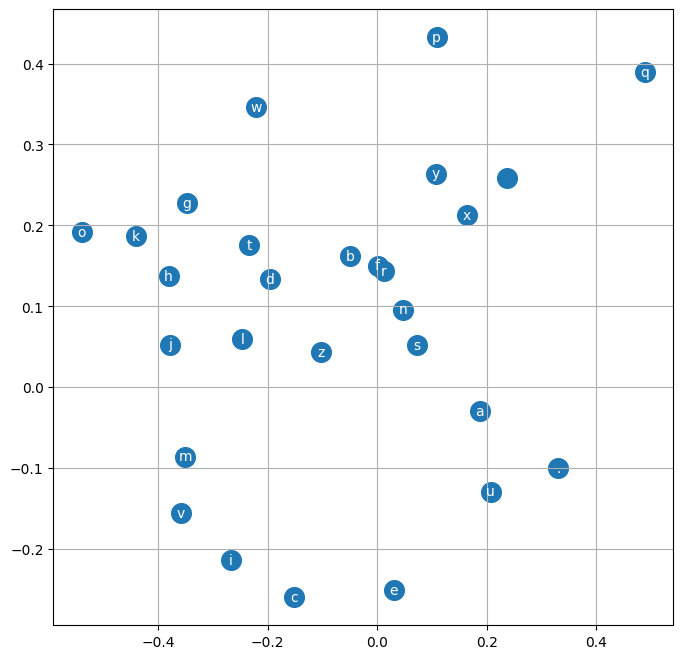

In [183]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [184]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1010, grad_fn=<NllLossBackward0>)

### So I beat 2.17 val loss as asked by andrej in this lecture

In [186]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1262, grad_fn=<NllLossBackward0>)

### Sampling from model

In [190]:
#g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      #ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

angi chatoushabiyah.
mai.
arliannilnisabbu rajetir.
kaylee.
veen.
mukhurjay giwar.
zaisa mirandrestin.
rajay.
ankajayna.
arar alla.
sadian.
chan.
aakash.
brle.
jaj.
adlia.
havenly.
jairettilyn.
nin.
brien.
